# Cloud Botany with DALES

## Setup

Cloud Botany is a library of idealised large-eddy simulations forced by and initialised with combinations of simplified vertical profiles. Each profile is parameterised by variables which aim to make the ensemble span a range of conditions corresponding to the variability observed over the EUREC<sup>4</sup>A region during the boreal winter of 2019/2020. The following table lists these varied parameters and their ranges:

```{list-table} Variables governing Cloud Botany simulations
:header-rows: 1
:name: botany-variables

* - variable
  - min
  - max
  - unit
  - description
* - `thls`
  - 297.5
  - 299.5
  - K
  - sea surface potential temperature
* - `u0`
  - -5
  - -15
  - m/s
  - surface wind
* - `qt0`
  - 0.0135
  - 0.015
  - kg/kg
  - mixed-layer total specific humidity
* - `qt_lambda`
  - 1200
  - 2500
  - m
  - humidity scale height
* - `thl_Gamma`
  - 4.5
  - 5.5
  - K/m
  - lapse rate of `thl`
* - `wpamp`
  - -0.5
  - 0.18
  - cm/s
  - Amplitude of subsidence first mode
* - `dudz`
  - -0.0044
  - 0.0044
  - 1/s
  - Wind shear[^1]
```

[^1]: Wind shear is only varied as a sweep over eight simulations and is otherwise constant. As such, it is not to be regarded as part of the core variables that are varied in Cloud Botany.

## Availability of simulation output

Cloud Botany contains simulations at a variety of grid resolutions and domain sizes, and each set of simulations comes with its own output. Most of this output is hosted and made available through [DKRZ's Swiftbrowser](https://docs.dkrz.de/doc/datastorage/swift/swiftbrowser.html), and can be accessed through the [`eurec4a-intake`](https://github.com/eurec4a/eurec4a-intake) catalog.

In [1]:
import eurec4a
cat = eurec4a.get_intake_catalog()
botany_cat = cat.simulations.DALES.botany

An overview over what is currently available through this structure is listed under {doc}`simulations`, and is repeated below for convenience:

In [2]:
def tree(cat, level=0):
    prefix = " " * (3*level)
    try:
        for child in list(cat):
            parameters = [p["name"] for p in cat[child].describe().get("user_parameters", [])]
            if len(parameters) > 0:
                parameter_str = " (" + ", ".join(parameters) + ")"
            else:
                parameter_str = ""
            print(prefix + str(child) + parameter_str)
            tree(cat[child], level+1)
    except:
        pass

tree(botany_cat)

dx100m


   nx1536
      profiles
      timeseries
      2D
      3D
      cross_xy
      radiation
      parameters


## Output description

### Parameters
A combination of grid resolution and domain size, e.g. `botany_cat.dx100.nx1536`, contains its own ensemble of cases. For now, only the combination `dx100` and `nx1536` can be accessed through the `eurec4a-intake` catalog, as this is the only configuration in which the full ensemble has been simulated. Other grid configurations might be added at a later stage.

To inspect and use the ensemble, start by loading its `parameters`:

In [3]:
import pandas as pd
varied_parameters = ['member','thls', 'u0', 'qt0', 'qt_lambda', 'thl_Gamma', 'wpamp', 'dudz', 'location']
parameters = cat.simulations.DALES.botany.dx100m.nx1536.parameters.read()
df_parameters = pd.DataFrame.from_records(parameters)[varied_parameters]
df_parameters

,member,thls,u0,qt0,qt_lambda,thl_Gamma,wpamp,dudz,location
0,1,298.5,-10.0,0.01425,1850.0,5.0,-0.00085,0.0022,center
1,2,297.5,-15.0,0.01350,1200.0,4.5,-0.00350,0.0022,corner
2,3,297.5,-15.0,0.01350,1200.0,4.5,0.00180,0.0022,corner
3,4,297.5,-15.0,0.01350,1200.0,5.5,-0.00350,0.0022,corner
4,5,297.5,-15.0,0.01350,1200.0,5.5,0.00180,0.0022,corner
...,...,...,...,...,...,...,...,...,...
98,99,298.5,-10.0,0.01425,2200.0,5.0,-0.00085,0.0022,sweep qt_lambda
99,100,298.5,-10.0,0.01425,2500.0,5.0,-0.00085,0.0022,sweep qt_lambda
100,101,298.5,-10.0,0.01425,3000.0,5.0,-0.00085,0.0022,sweep qt_lambda
101,102,298.5,-10.0,0.01350,1850.0,5.0,-0.00085,0.0022,sweep qt0


`parameters` contains the value of the variables in {numref}`botany-variables`, as they vary for each `member` of the ensemble. The ensemble may be thought of a hypercube in the six-dimensional space spanned by `[thls, u0, qt0, qt_lambda, thl_Gamma, wpamp]`. The `location` column indicates where any `member` fits in this space:
- The hypercube `center` represents the middle of the range between the minimum and maximum value of each variable
- The hypercube `corner`s are constructed by evaluating all parameter combinations at their minimum and maximum (resulting in the next $2^6 = 64$ simulations). 
- Simulations belonging to a `sweep` have a single variable vary between its minimum and maximum, while keeping all other variables constant at their `center` value.

### Simulation output
The actual output from the simulations is stored in the other data sets in the tree listing above. Such data sets can be loaded according to the following example:

In [4]:
import xarray as xr

ds_profiles = botany_cat.dx100m.nx1536['profiles'].to_dask()
ds_profiles

<xarray.Dataset>
Dimensions:    (member: 103, time: 720, zt: 175, zm: 175)
Coordinates:
  * member     (member) int32 1 2 3 4 5 6 7 8 9 ... 96 97 98 99 100 101 102 103
  * time       (time) datetime64[ns] 2020-02-01T00:05:00 ... 2020-02-03T12:00:00
  * zm         (zm) float32 0.0 15.0 30.0 45.3 ... 6.772e+03 6.854e+03 6.938e+03
  * zt         (zt) float32 7.5 22.5 37.65 ... 6.813e+03 6.896e+03 6.98e+03
Data variables: (12/102)
    cfrac      (member, time, zt) float32 dask.array<chunksize=(32, 256, 175), meta=np.ndarray>
    cs         (member, time, zt) float32 dask.array<chunksize=(32, 256, 175), meta=np.ndarray>
    dvrmn      (member, time, zt) float32 dask.array<chunksize=(32, 256, 175), meta=np.ndarray>
    lwd        (member, time, zm) float32 dask.array<chunksize=(32, 256, 175), meta=np.ndarray>
    lwdca      (member, time, zm) float32 dask.array<chunksize=(32, 256, 175), meta=np.ndarray>
    lwu        (member, time, zm) float32 dask.array<chunksize=(32, 256, 175), meta=np.ndarray>
    ...         ...
    wthlr      (member, time, zm) float32 dask.array<chunksize=(32, 256, 175), meta=np.ndarray>
    wthls      (member, time, zm) float32 dask.array<chunksize=(32, 256, 175), meta=np.ndarray>
    wthlt      (member, time, zm) float32 dask.array<chunksize=(32, 256, 175), meta=np.ndarray>
    wthvr      (member, time, zm) float32 dask.array<chunksize=(32, 256, 175), meta=np.ndarray>
    wthvs      (member, time, zm) float32 dask.array<chunksize=(32, 256, 175), meta=np.ndarray>
    wthvt      (member, time, zm) float32 dask.array<chunksize=(32, 256, 175), meta=np.ndarray>
Attributes:
    Author:   
    Source:   DALES 4.2 git: v4.3-108-gca69cb
    history:  Created on 20220520 at 213340.423
    title:    profiles.001.nc

Briefly summmarised, the individual data sets contain:

| Name     | What is it? | Dimensions | Output frequency |
|----------|-------------|------------|------------------|
| `profiles` | Vertical profiles of dynamic, thermodynamic, radiation, and microphysical slab statistics | `[member, time, z]` | 5 min |
| `timeseries` | Surface and bulk statistics | `[member, time]` | 1 min |
| `2D` | Vertically integrated and surface diagnostics | `[member, time, x, y]` | 5 min |
| `3D` | Full field dumps of prognostic variables and liquid water specific humidity | `[member, time, x, y, z]` | 1 hour |
| `cross_xy` | Extracted horizontal cross-sections of prognostic variables and liquid water specific humidity | `[member, time, x, y, z]` | 5 min |
| `radiation` | Radiation model output at surface and top of atmosphere | `[member, time, x, y]` | 1 hour |

## Examples and visualisations

Here are three short examples of accessing and plotting Botany output.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use(["./mplstyle/book", "./mplstyle/wide"])

### An overview over the initial profiles of Botany

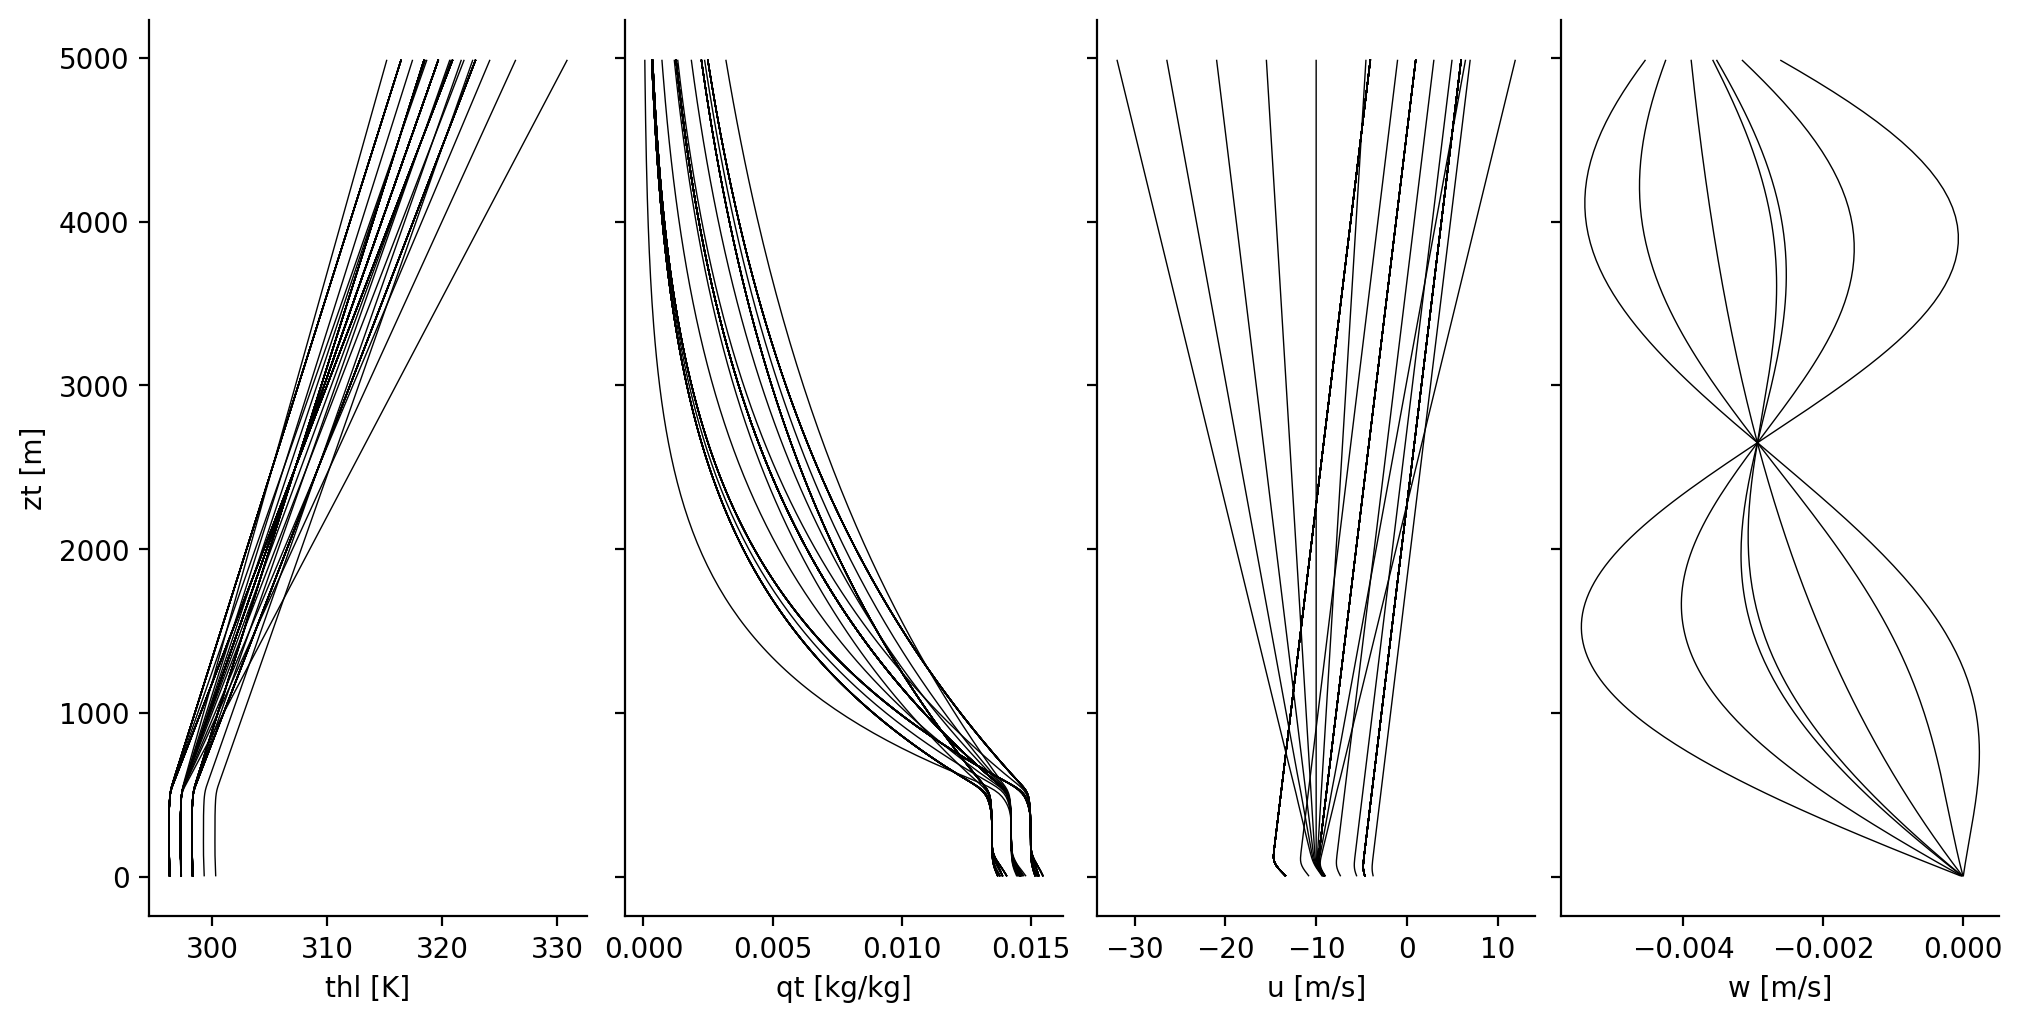

In [6]:
# Profiles of vertical velocity, from variations in first-mode amplitude
def expsinw(z, ampwp, w0=0.0045, Hw=2500, Hwp=5300):
    '''
    Vertical profiles for imposed, large-scale subsidence velocity
    '''
    w_0 = -w0*(1-np.exp(-z/Hw))
    w_1 = ampwp*np.sin(2.*np.pi/Hwp*z)
    w_1[z>Hwp] = 0.
    return w_0 + w_1

wpamp = np.unique(pd.DataFrame.from_records(parameters)[['wpamp']].to_numpy())

ds_initial = ds_profiles.isel(time=0).sel(zt=slice(0, 5000))

kws = {'y'          : 'zt',
       'add_legend' : False,
       'linewidth'  : 0.5,
       'c'          : 'k'}

fig, axs = plt.subplots(ncols=4, sharey=True, figsize=(10,5))

ds_initial['thl'].plot.line(ax=axs[0], **kws)
ds_initial['qt'].plot.line(ax=axs[1], **kws)
ds_initial['u'].plot.line(ax=axs[2], **kws)

for i, wpampi in enumerate(wpamp):
    axs[3].plot(expsinw(ds_initial['zt'], wpampi), ds_initial['zt'], linewidth=0.5, c='k')
axs[3].set_xlabel('w [m/s]')
    
for i in range(axs.size):
    axs[i].set_title('')
    if i > 0:
        axs[i].set_ylabel('')

plt.show()

### Variability of cloud fraction with surface wind

One way to study how simulation output varies with the `parameters` is to add a variable of interest to one's loaded `xarray.Dataset`:

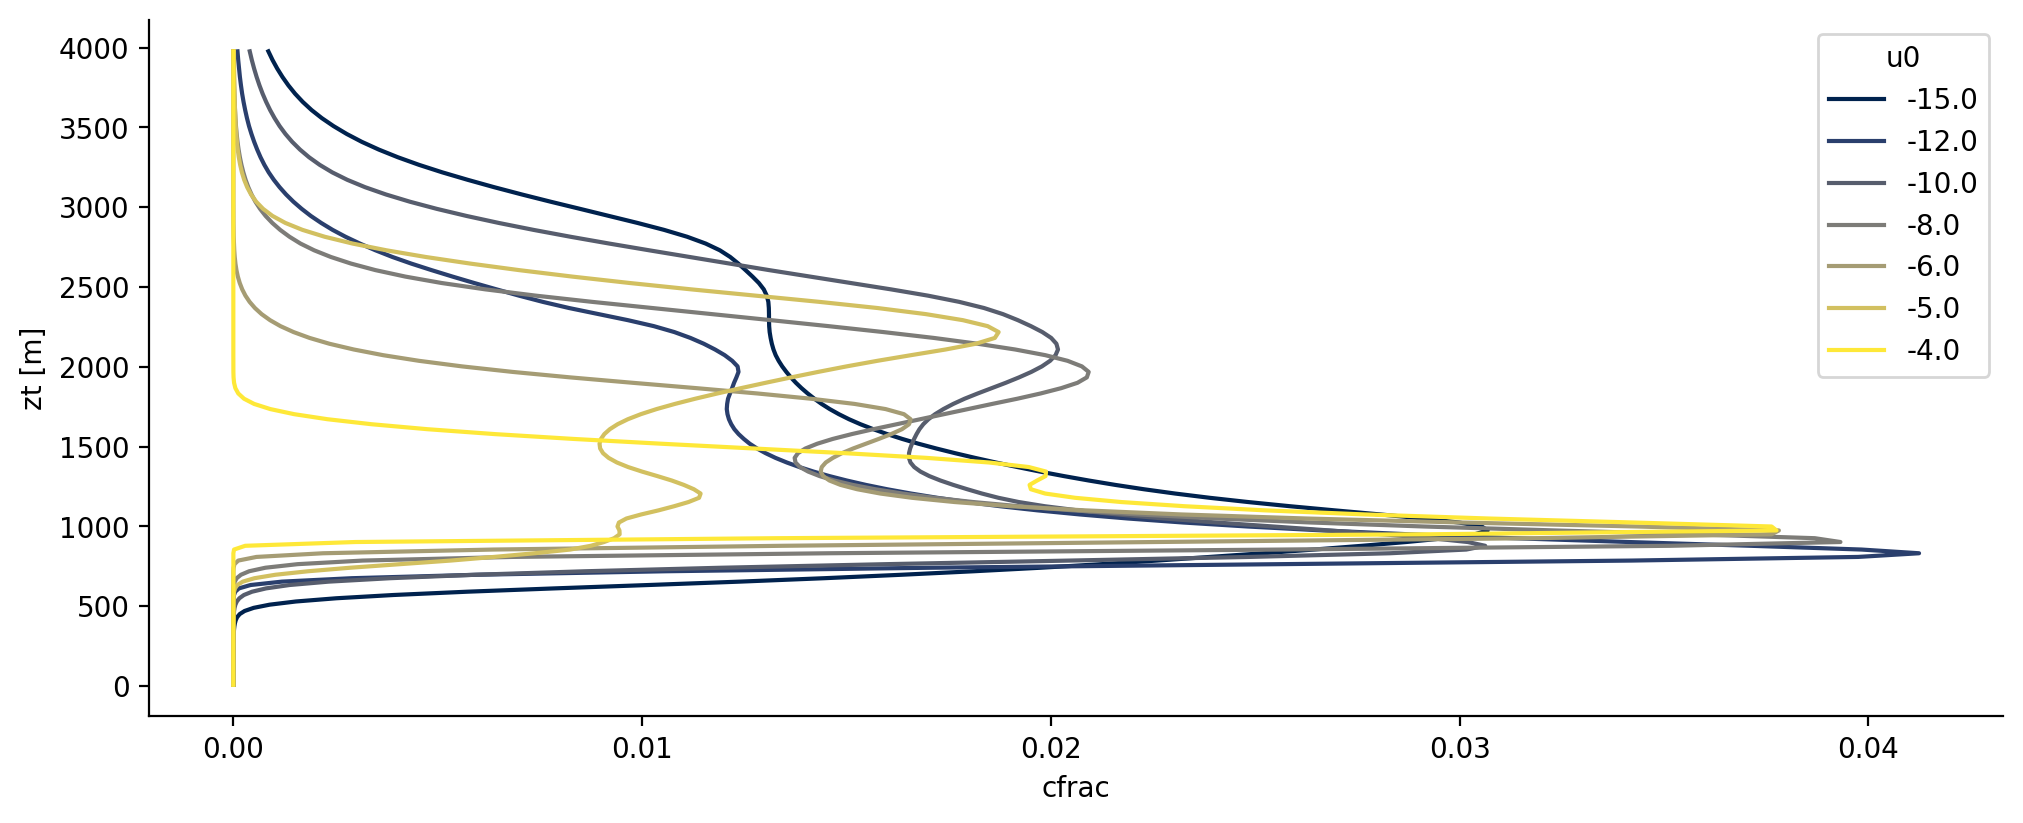

In [7]:
from cycler import cycler

fig = plt.figure()
ax = plt.gca()
ax.set_prop_cycle(cycler(color=plt.cm.cividis(np.linspace(0, 1, 7))))

# Add u0 to the profiles output
ds_u = ds_profiles.assign(df_parameters[['member','u0']].set_index('member').to_xarray())

# Plot mean cloud fraction profiles grouped by surface wind over the last 100 time steps of all simulations
ds_u[['cfrac','u0']].isel(time=slice(-100,-1)).sel(zt = slice(0,4000)).mean(dim='time').groupby('u0').mean()['cfrac'].plot.line(ax=ax, y='zt')
plt.show()

### Example visualisation of water vapour, clouds, rain and cold pools
For the last time (60 hours after initialisation) for the "center" of the hypercube of simulations (member 1), we might visualise the vertically integrated total specific humidity (the total water path `twp`), the cloud-top height (`cldtop`), the rain-water path (`rwp`) and an indicator for the extent of cold pools (the local mixed-layer height, `hmix`), as follows:

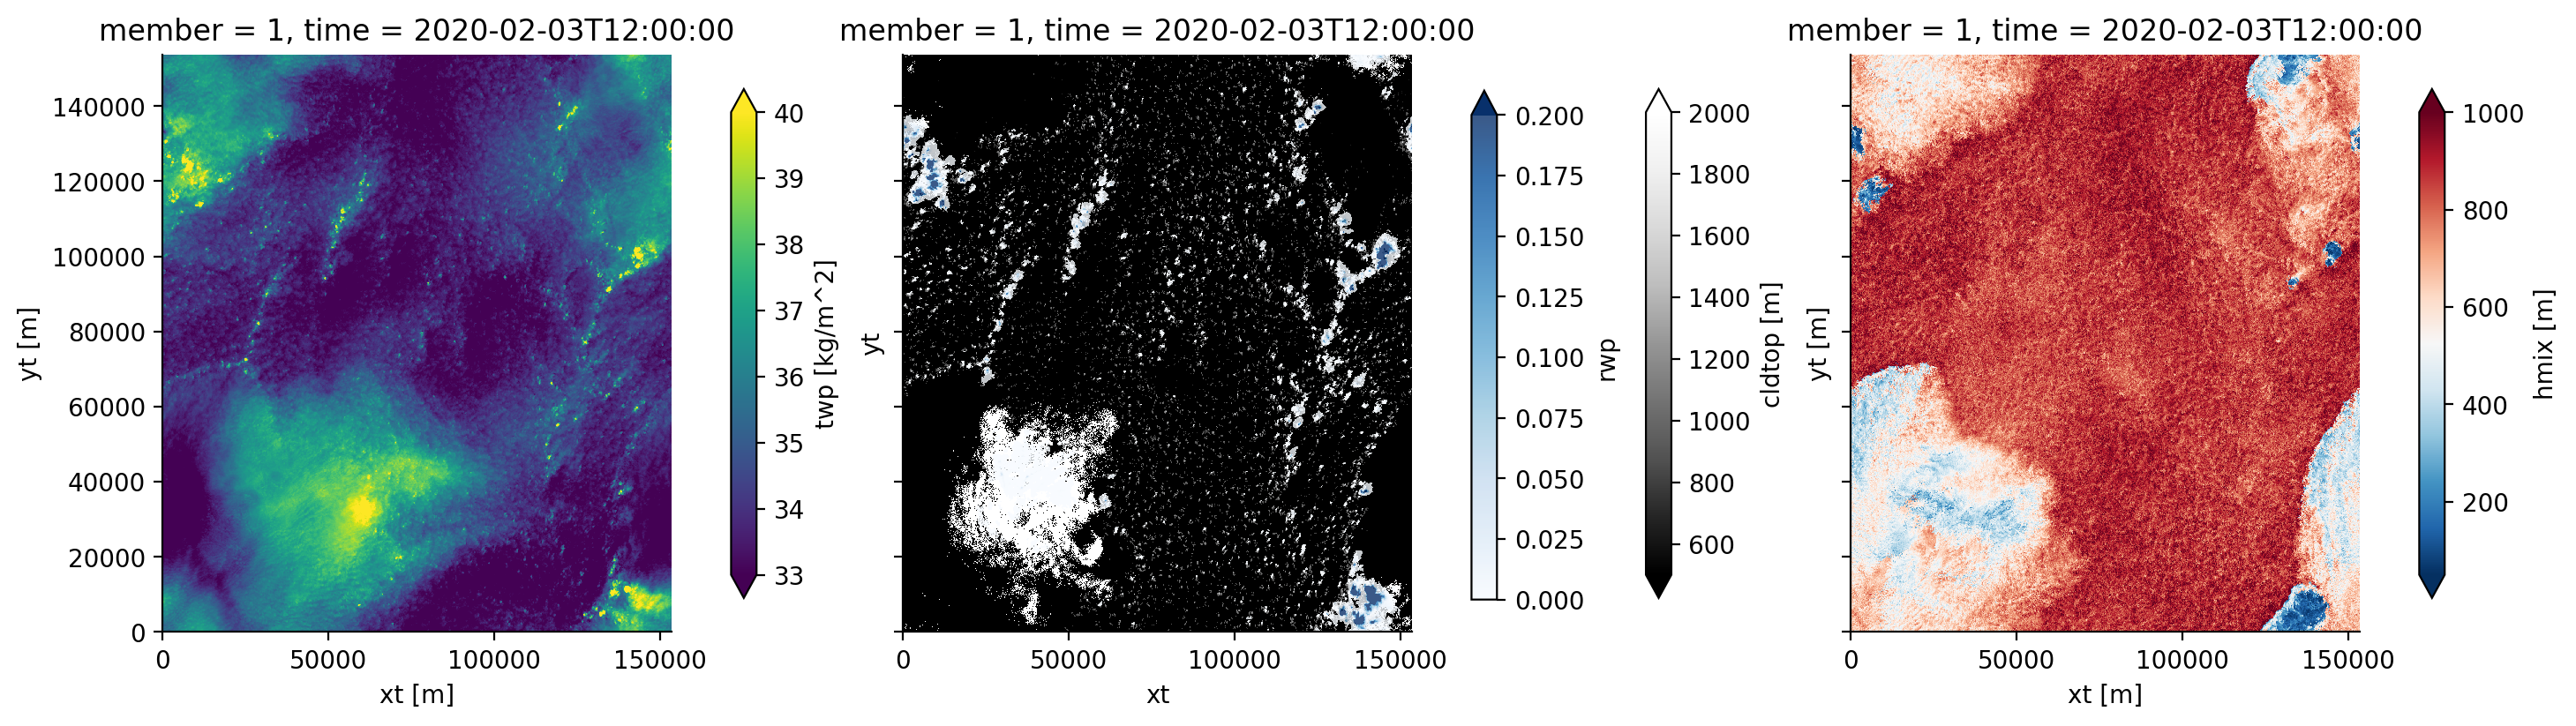

In [8]:
cb_kw = {'fraction' : 0.05}

ds_2D = botany_cat.dx100m.nx1536['2D'].to_dask().sel(member=1).isel(time=-1)
ds_2D
fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(14.5,4))

# Total water path
ds_2D['twp'].plot(ax=axs[0], vmin=33 ,vmax=40, cbar_kwargs=cb_kw)

# Cloud-top height and rain water path
ds_2D['cldtop'].plot(ax=axs[1],cmap='Greys_r', vmin=500, vmax=2000, cbar_kwargs=cb_kw)
rwp_masked = xr.where(ds_2D['rwp'] > 1e-5, ds_2D['rwp'], np.nan)
rwp_masked.plot(ax=axs[1], cmap='Blues', vmin=0, vmax=0.2, alpha=0.8, cbar_kwargs=cb_kw)

# Mixed-layer height
ds_2D['hmix'].plot(ax=axs[2],cmap='RdBu_r', vmin=50, vmax=1000, cbar_kwargs=cb_kw)

plt.show()

### Visualisations page

In addition to the data sets described above, a more thorough set of visualisations indicative simulation output is available. This visualisation set contains simple overviews and movies for each simulation in the library. They can be quite useful for attaining a basic idea of what each simulation produced without having to load the data. These visualisations are hosted on [a personal server](http://143.178.154.95:3141/), so in contrast to the data hosted on DKRZ, we warn that its maintenance and availability may be patchy.